# ДЗ 1 — Прогноз оттока клиентов (Telecom Churn) — EDA

**Цель:** постановка задачи, выбор метрики и разведочный анализ данных (EDA)

## 1. Постановка задачи

**ML-постановка.** Супервайз-задача бинарной классификации: по признакам клиента (услуги, платежи, стаж, демография) предсказать целевую метку `Churn ∈ {Yes, No}`.


Основная метрика — F1-score по положительному классу (Churn=Yes).  
Обоснование: класс несбалансирован, accuracy может вводить в заблуждение. F1 балансирует precision и recall.


## 3. Импорт библиотек

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.set_option("display.max_columns", 200)
sns.set_theme()

## 4. Загрузка данных с Kaggle через kagglehub

In [2]:
try:
    import kagglehub  # noqa: F401
    print("kagglehub: OK")
except Exception as e:
    import sys, subprocess
    print("Устанавливаю kagglehub...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "kagglehub"])
    import kagglehub  # noqa: F401
    print("kagglehub установлен")


kagglehub: OK


In [3]:
import kagglehub

# Скачиваем последнюю версию датасета
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
print("Путь к файлам датасета:", path)

Using Colab cache for faster access to the 'telco-customer-churn' dataset.
Путь к файлам датасета: /kaggle/input/telco-customer-churn


In [4]:
# Поиск CSV
csv_path = None
for root, dirs, files in os.walk(path):
    for f in files:
        if f.endswith(".csv") and "Telco" in f:
            csv_path = os.path.join(root, f)
            break
    if csv_path:
        break

print("Найден файл:", csv_path)


Найден файл: /kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [5]:
#Загрузка данных
df_raw = pd.read_csv(csv_path)
df_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Короткий вывод:** данные загружены; целевая переменная — `Churn`.


## 5. Быстрый осмотр

In [6]:
df_raw.shape

(7043, 21)

In [7]:
df_raw.dtypes

,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


In [8]:
df_raw.sample(5, random_state=42)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
185,1024-GUALD,Female,0,Yes,No,1,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,24.80,24.8,Yes
2715,0484-JPBRU,Male,0,No,No,41,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer (automatic),25.25,996.45,No
3825,3620-EHIMZ,Female,0,Yes,Yes,52,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.35,1031.7,No
1807,6910-HADCM,Female,0,No,No,1,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Electronic check,76.35,76.35,Yes
132,8587-XYZSF,Male,0,No,No,67,Yes,No,DSL,No,No,No,Yes,No,No,Two year,No,Bank transfer (automatic),50.55,3260.1,No


**Короткий вывод:** набор содержит смешанные типы, много категориальных признаков.

## 6. Лёгкая очистка

In [9]:
df = df_raw.copy()

In [10]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].isna().sum()

np.int64(11)

In [11]:
df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)
df.shape

(7032, 21)

In [12]:
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])
df.shape


(7032, 20)

**Короткий вывод:** **Короткий вывод:** привели `TotalCharges` к числу; удалили несколько строк с пропусками; убрали идентификатор.


## 7. Целевая переменная `Churn`

In [13]:
target_counts = df['Churn'].value_counts()
target_counts


,count
Churn,
No,5163
Yes,1869


/tmp/ipython-input-83480696.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Churn', palette='Set2', edgecolor='black')


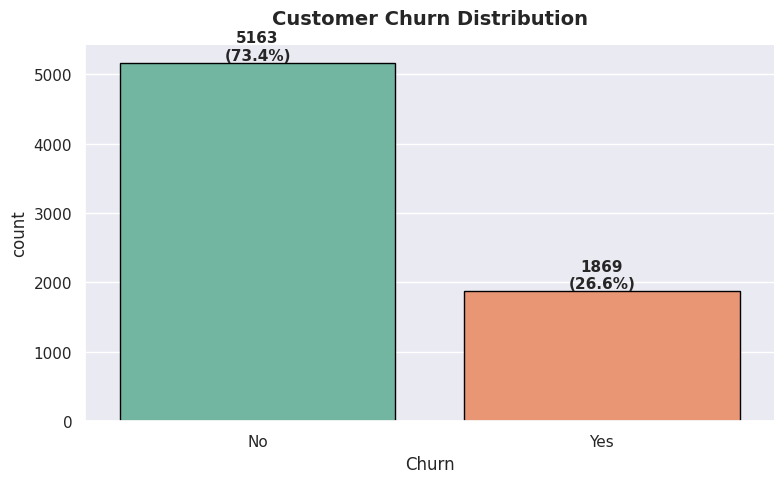

In [15]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x='Churn', palette='Set2', edgecolor='black')

for p in ax.patches:
    count = int(p.get_height())
    pct = f'{100 * count / len(df):.1f}%'
    ax.text(p.get_x() + p.get_width()/2, p.get_height(),
            f'{count}\n({pct})', ha='center', va='bottom', fontsize=11, weight='bold')

plt.title('Customer Churn Distribution', fontsize=14, weight='bold', pad=15)
sns.despine()
plt.tight_layout()
plt.show()

**Короткий вывод:** выраженный дисбаланс классов — Churn=Yes заметно меньше.

## 8. Распределения числовых признаков

In [54]:
num_cols = ['tenure','MonthlyCharges','TotalCharges']; df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


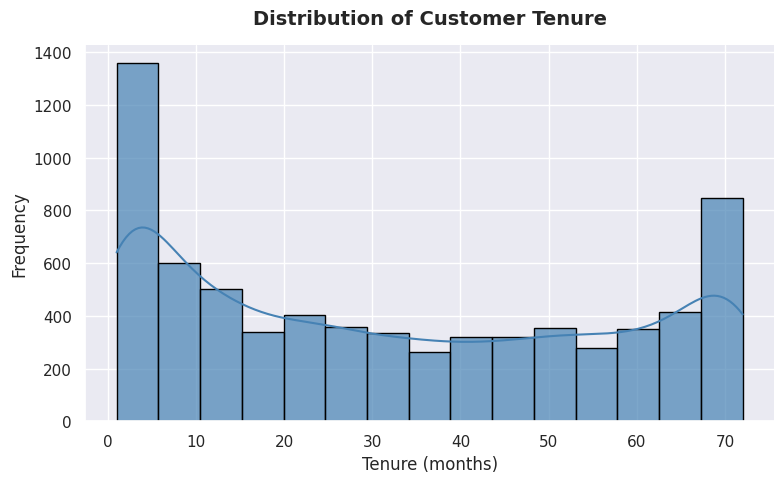

In [16]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="tenure", kde=True, color='steelblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Customer Tenure', fontsize=14, weight='bold', pad=15)
plt.xlabel('Tenure (months)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

**Короткий вывод.** Распределение `tenure` **U-образное**: много «новичков» (≈0–6 мес.) и заметный пик у долгоживущих клиентов (≈60–72 мес.), при этом **середина (≈20–50 мес.) просажена**. Это намекает на две различные группы пользователей и потенциально более высокий риск оттока среди клиентов с коротким стажем.


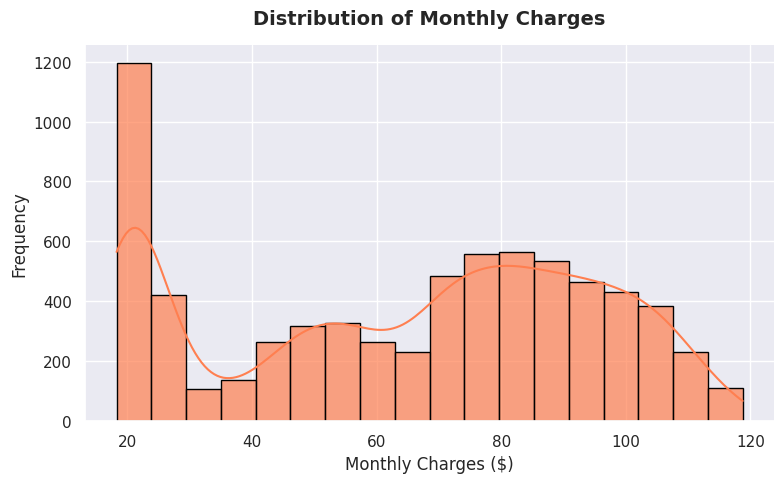

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="MonthlyCharges", kde=True, color='coral', edgecolor='black', alpha=0.7)
plt.title('Distribution of Monthly Charges', fontsize=14, weight='bold', pad=15)
plt.xlabel('Monthly Charges ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

**Короткий вывод.** `MonthlyCharges` имеет **мультимодальную** форму и **правый хвост** до ≈120: виден небольшой пик у низких платежей (≈20–30), затем основной «горб» в диапазоне **≈70–90**. Такая форма указывает на **разные тарифные/сервисные пакеты** и возможную нелинейную связь с оттоком (высокие ежемесячные платежи часто ассоциируются с большим риском).


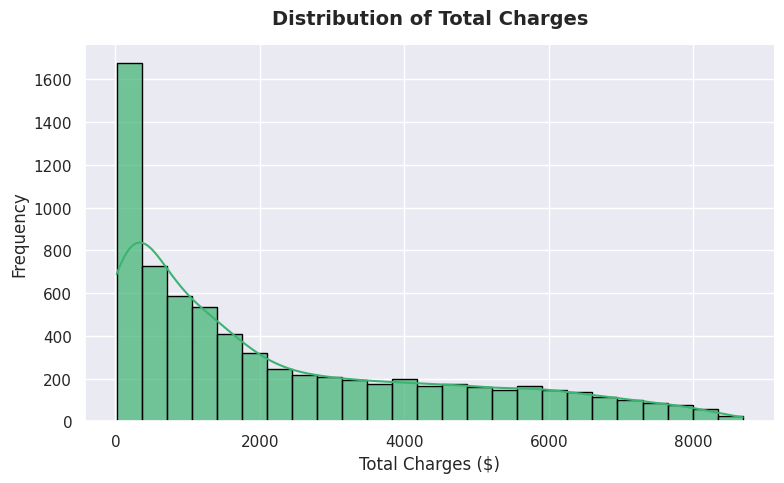

In [18]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="TotalCharges", kde=True, color='mediumseagreen', edgecolor='black', alpha=0.7)
plt.title('Distribution of Total Charges', fontsize=14, weight='bold', pad=15)
plt.xlabel('Total Charges ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()


**Короткий вывод.** `TotalCharges` сильно **право-скошено** (длинный хвост): много наблюдений с малыми суммами и убывающая частота к большим значениям. Это ожидаемо, так как `TotalCharges` ≈ `tenure × MonthlyCharges`: новые или краткосрочные клиенты концентрируются слева.



## 9. Числовые признаки по классам (KDE)

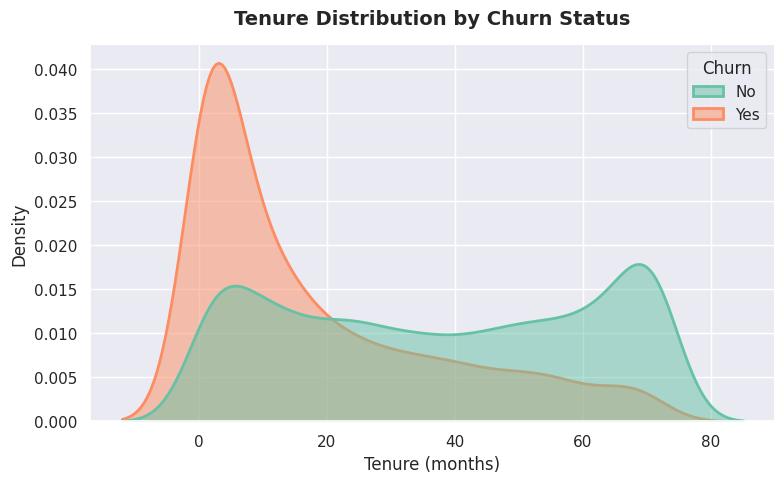

In [30]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x="tenure", hue="Churn", fill=True, alpha=0.5, linewidth=2, common_norm=False, palette='Set2')
plt.title('Tenure Distribution by Churn Status', fontsize=14, weight='bold', pad=15)
plt.xlabel('Tenure (months)', fontsize=12)
plt.ylabel('Density', fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

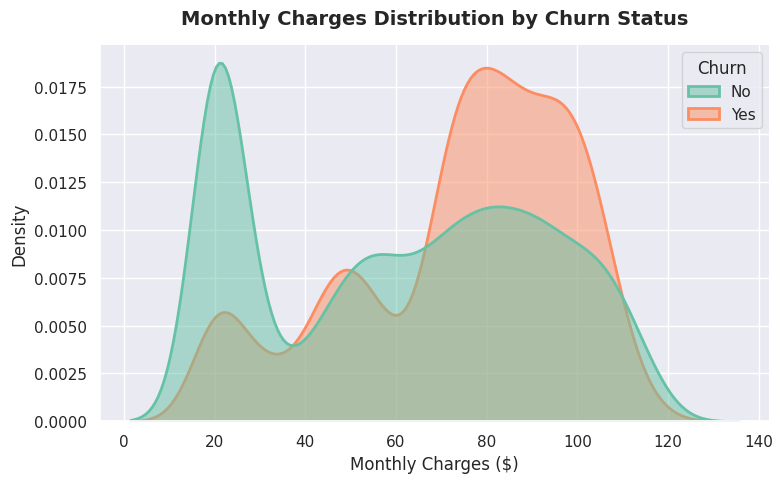

In [31]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x="MonthlyCharges", hue="Churn", fill=True, alpha=0.5, linewidth=2, common_norm=False, palette='Set2')
plt.title('Monthly Charges Distribution by Churn Status', fontsize=14, weight='bold', pad=15)
plt.xlabel('Monthly Charges ($)', fontsize=12)
plt.ylabel('Density', fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()


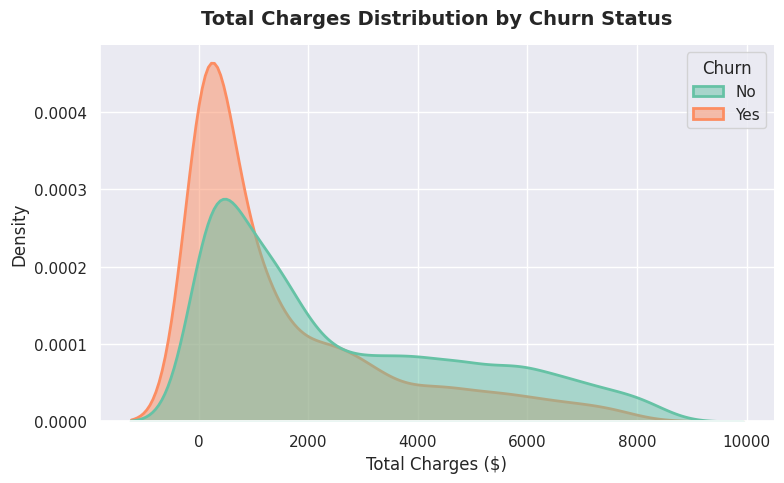

In [32]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x="TotalCharges", hue="Churn", fill=True, alpha=0.5, linewidth=2, common_norm=False, palette='Set2')
plt.title('Total Charges Distribution by Churn Status', fontsize=14, weight='bold', pad=15)
plt.xlabel('Total Charges ($)', fontsize=12)
plt.ylabel('Density', fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

**Короткий вывод.**  
На графиках видно отчётливое различие распределений признаков между группами `Churn=Yes` и `Churn=No`.  

- Для `tenure`: клиенты, которые покинули компанию (`Yes`), концентрируются в области **малого стажа (0–10 мес.)**, тогда как оставшиеся (`No`) чаще имеют **длительный стаж (60+ мес.)**. Это подтверждает гипотезу о риске оттока среди новых клиентов.  
- Для `MonthlyCharges`: ушедшие клиенты имеют **более высокие ежемесячные платежи (≈70–100)**, в то время как оставшиеся чаще платят **меньше 50**. Вероятно, высокие тарифы усиливают вероятность оттока.  
- Для `TotalCharges`: распределение схоже по форме, но клиенты с `Churn=Yes` чаще имеют **меньшие общие суммы**, что логично — они покидают компанию раньше.  

Эти зависимости указывают, что **стаж клиента** и **уровень платежей** — важные факторы, влияющие на вероятность оттока.


## 10. Выбросы (boxplot и IQR)

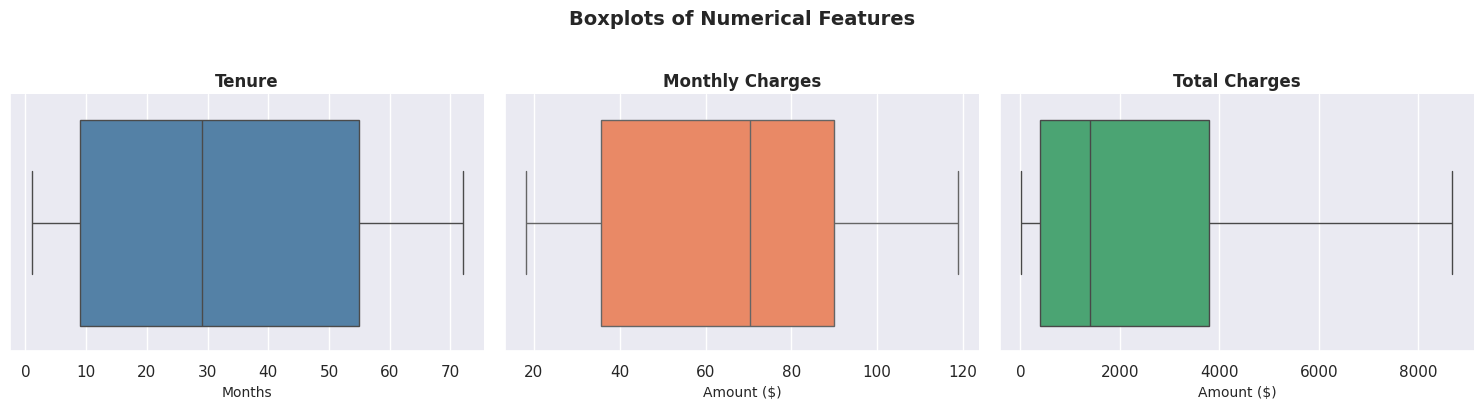

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.boxplot(x=df["tenure"], ax=axes[0], color='steelblue')
axes[0].set_title('Tenure', fontsize=12, weight='bold')
axes[0].set_xlabel('Months', fontsize=10)

sns.boxplot(x=df["MonthlyCharges"], ax=axes[1], color='coral')
axes[1].set_title('Monthly Charges', fontsize=12, weight='bold')
axes[1].set_xlabel('Amount ($)', fontsize=10)

sns.boxplot(x=df["TotalCharges"], ax=axes[2], color='mediumseagreen')
axes[2].set_title('Total Charges', fontsize=12, weight='bold')
axes[2].set_xlabel('Amount ($)', fontsize=10)

plt.suptitle('Boxplots of Numerical Features', fontsize=14, weight='bold', y=1.02)
sns.despine()
plt.tight_layout()
plt.show()

**Короткий вывод.**  
Boxplot-графики показывают распределение значений и возможные выбросы для трёх числовых признаков.  

- Для `tenure`: значения распределены относительно равномерно, медиана около 35 месяцев, явных выбросов нет. Это согласуется с U-образной формой распределения — две группы клиентов по стажу.  
- Для `MonthlyCharges`: разброс широкий (≈20–120), медиана около 70. Выбросов также не наблюдается, данные относительно симметричны.  
- Для `TotalCharges`: наблюдается выраженный **асимметричный правый хвост**, что отражает наличие клиентов с очень высокими накопленными суммами. Это естественно, так как общий платёж растёт со стажем.  



In [34]:
def iqr_outliers_count(s: pd.Series):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    mask = (s < low) | (s > high)
    return int(mask.sum()), float(low), float(high)

out_report = {}
for c in ['tenure','MonthlyCharges','TotalCharges']:
    n_out, low, high = iqr_outliers_count(df[c])
    out_report[c] = {"n_outliers": n_out, "low_thr": low, "high_thr": high}

pd.DataFrame(out_report).T

,n_outliers,low_thr,high_thr
tenure,0.0,-60.00000,124.00000
MonthlyCharges,0.0,-45.82500,171.27500
TotalCharges,0.0,-4688.48125,8884.66875


**Короткий вывод:** выбросов нет; можно оставить как есть

## 11. Категориальные признаки и отток

In [35]:
def churn_rate_by_cat(df, feature):
    ct = (df.groupby(feature)['Churn']
            .value_counts(normalize=True)
            .rename('prop')
            .reset_index())
    return ct[ct['Churn']=='Yes'].sort_values('prop', ascending=False)

### Contract

In [36]:
tmp = churn_rate_by_cat(df, "Contract")
tmp

,Contract,Churn,prop
1,Month-to-month,Yes,0.427097
3,One year,Yes,0.112772
5,Two year,Yes,0.028487


/tmp/ipython-input-3591648257.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=tmp, x="Contract", y="prop", palette='Set2', edgecolor='black')


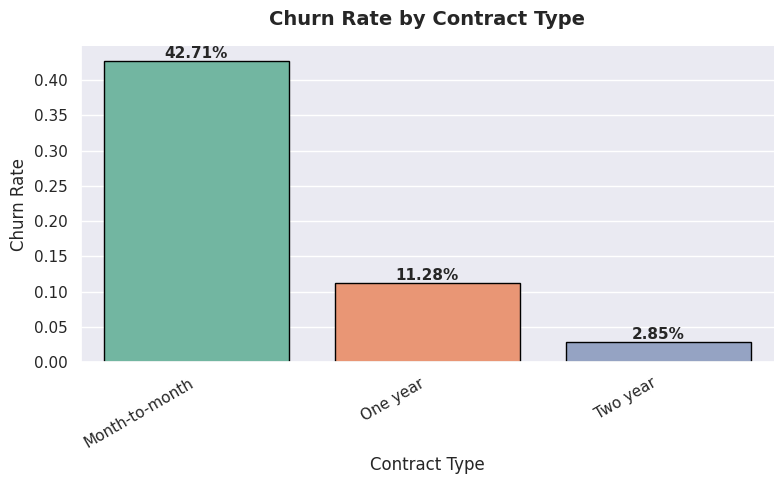

In [37]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=tmp, x="Contract", y="prop", palette='Set2', edgecolor='black')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height(),
            f'{p.get_height():.2%}', ha='center', va='bottom', fontsize=11, weight='bold')

plt.title('Churn Rate by Contract Type', fontsize=14, weight='bold', pad=15)
plt.xlabel('Contract Type', fontsize=12)
plt.ylabel('Churn Rate', fontsize=12)
plt.xticks(rotation=30, ha='right', fontsize=11)
sns.despine()
plt.tight_layout()
plt.show()

In [38]:
tmp = churn_rate_by_cat(df, "PaymentMethod")
tmp


,PaymentMethod,Churn,prop
5,Electronic check,Yes,0.452854
7,Mailed check,Yes,0.192020
1,Bank transfer (automatic),Yes,0.167315
3,Credit card (automatic),Yes,0.152531


/tmp/ipython-input-2977835204.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=tmp, x="PaymentMethod", y="prop", palette='Set2', edgecolor='black')


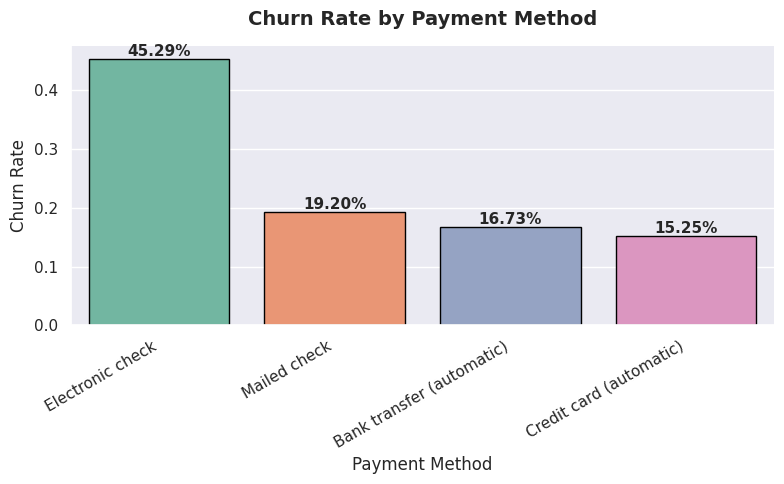

In [41]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=tmp, x="PaymentMethod", y="prop", palette='Set2', edgecolor='black')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height(),
            f'{p.get_height():.2%}', ha='center', va='bottom', fontsize=11, weight='bold')

plt.title('Churn Rate by Payment Method', fontsize=14, weight='bold', pad=15)
plt.xlabel('Payment Method', fontsize=12)
plt.ylabel('Churn Rate', fontsize=12)
plt.xticks(rotation=30, ha='right', fontsize=11)
sns.despine()
plt.tight_layout()
plt.show()

In [42]:
tmp = churn_rate_by_cat(df, "PaperlessBilling")
tmp

,PaperlessBilling,Churn,prop
3,Yes,Yes,0.335893
1,No,Yes,0.163757


/tmp/ipython-input-3882651496.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=tmp, x="PaperlessBilling", y="prop", palette='Set2', edgecolor='black')


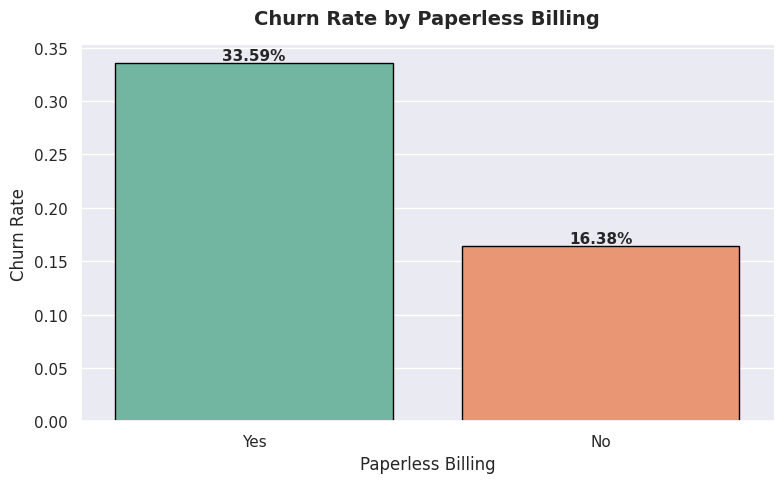

In [43]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=tmp, x="PaperlessBilling", y="prop", palette='Set2', edgecolor='black')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height(),
            f'{p.get_height():.2%}', ha='center', va='bottom', fontsize=11, weight='bold')

plt.title('Churn Rate by Paperless Billing', fontsize=14, weight='bold', pad=15)
plt.xlabel('Paperless Billing', fontsize=12)
plt.ylabel('Churn Rate', fontsize=12)
plt.xticks(fontsize=11)
sns.despine()
plt.tight_layout()
plt.show()

In [44]:
tmp = churn_rate_by_cat(df, "InternetService")
tmp


,InternetService,Churn,prop
3,Fiber optic,Yes,0.418928
1,DSL,Yes,0.189983
5,No,Yes,0.074342


/tmp/ipython-input-124384342.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=tmp, x="InternetService", y="prop", palette='Set2', edgecolor='black')


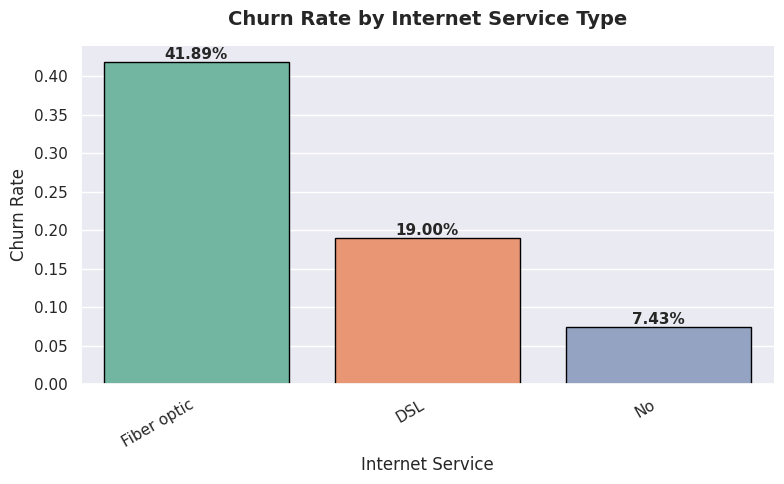

In [45]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=tmp, x="InternetService", y="prop", palette='Set2', edgecolor='black')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height(),
            f'{p.get_height():.2%}', ha='center', va='bottom', fontsize=11, weight='bold')

plt.title('Churn Rate by Internet Service Type', fontsize=14, weight='bold', pad=15)
plt.xlabel('Internet Service', fontsize=12)
plt.ylabel('Churn Rate', fontsize=12)
plt.xticks(rotation=30, ha='right', fontsize=11)
sns.despine()
plt.tight_layout()
plt.show()

In [46]:
tmp = churn_rate_by_cat(df, "TechSupport")
tmp

,TechSupport,Churn,prop
1,No,Yes,0.416475
5,Yes,Yes,0.151961
3,No internet service,Yes,0.074342


/tmp/ipython-input-1066963525.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=tmp, x="TechSupport", y="prop", palette='Set2', edgecolor='black')


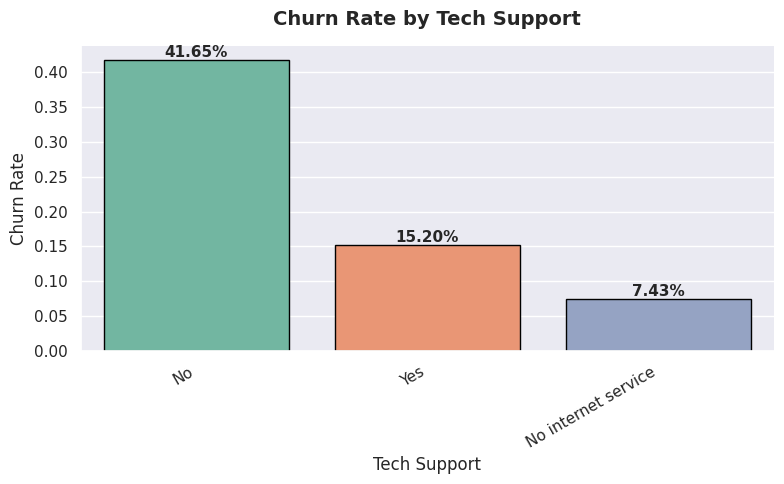

In [47]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=tmp, x="TechSupport", y="prop", palette='Set2', edgecolor='black')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height(),
            f'{p.get_height():.2%}', ha='center', va='bottom', fontsize=11, weight='bold')

plt.title('Churn Rate by Tech Support', fontsize=14, weight='bold', pad=15)
plt.xlabel('Tech Support', fontsize=12)
plt.ylabel('Churn Rate', fontsize=12)
plt.xticks(rotation=30, ha='right', fontsize=11)
sns.despine()
plt.tight_layout()
plt.show()

In [48]:
tmp = churn_rate_by_cat(df, "OnlineSecurity")
tmp

,OnlineSecurity,Churn,prop
1,No,Yes,0.417787
5,Yes,Yes,0.146402
3,No internet service,Yes,0.074342


/tmp/ipython-input-879903241.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=tmp, x="OnlineSecurity", y="prop", palette='Set2', edgecolor='black')


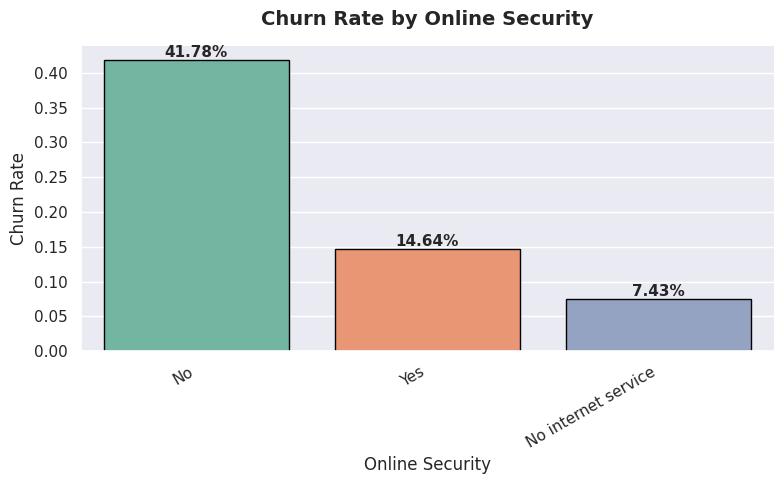

In [49]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=tmp, x="OnlineSecurity", y="prop", palette='Set2', edgecolor='black')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height(),
            f'{p.get_height():.2%}', ha='center', va='bottom', fontsize=11, weight='bold')

plt.title('Churn Rate by Online Security', fontsize=14, weight='bold', pad=15)
plt.xlabel('Online Security', fontsize=12)
plt.ylabel('Churn Rate', fontsize=12)
plt.xticks(rotation=30, ha='right', fontsize=11)
sns.despine()
plt.tight_layout()
plt.show()


**Короткий вывод.**  
Анализ категориальных признаков показывает чёткие различия в доле оттока (`Churn=Yes`) между группами клиентов:  

- **Contract:** максимальный отток у клиентов с помесячным контрактом (**≈43%**), тогда как при годовом контракте он снижается до **≈11%**, а при двухлетнем — почти исчезает (**≈3%**). Это указывает на важность долгосрочных обязательств для удержания клиентов.  
- **PaymentMethod:** наибольший отток наблюдается при оплате **через Electronic check (≈45%)**, что может быть связано с более низкой лояльностью или отсутствием автоматизации платежей. Клиенты, использующие автоматические методы (банк, кредитка), уходят значительно реже.  
- **PaperlessBilling:** электронная форма счёта ассоциируется с более высоким уровнем оттока (**≈34%** против **≈16%** у тех, кто получает бумажный счёт).
- **InternetService:** пользователи **Fiber optic** демонстрируют наибольший отток (**≈42%**), тогда как у **DSL** он умеренный (**≈19%**) и минимальный у тех, кто не пользуется интернетом. Возможно, клиенты оптоволокна чувствительнее к цене или качеству сервиса.  
- **TechSupport** и **OnlineSecurity:** отток наиболее высок среди клиентов, **не подключивших эти сервисы** (**≈41%**), и значительно ниже у тех, кто их использует (**≈15%**). Это подчёркивает значимость дополнительных услуг поддержки и безопасности для удержания клиентов.  

В целом, данные показывают, что **тип контракта, способ оплаты и наличие сервисов поддержки/безопасности** оказывают существенное влияние на риск оттока.


## 12. Корреляции числовых признаков

In [50]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr(method='pearson')
corr

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.015683,0.219874,0.102411
tenure,0.015683,1.000000,0.246862,0.825880
MonthlyCharges,0.219874,0.246862,1.000000,0.651065
TotalCharges,0.102411,0.825880,0.651065,1.000000


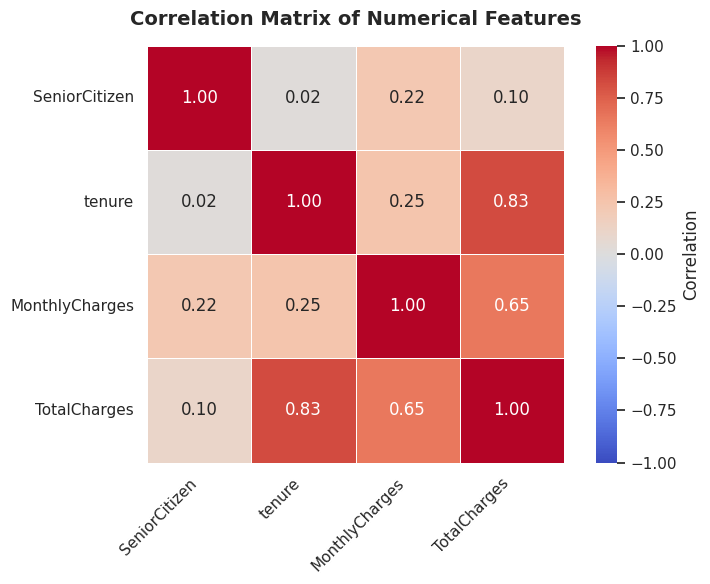

In [52]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5,
            cbar_kws={'label': 'Correlation'}, square=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features', fontsize=14, weight='bold', pad=15)
plt.xticks(fontsize=11, rotation=45, ha='right')
plt.yticks(fontsize=11, rotation=0)
plt.tight_layout()
plt.show()

**Короткий вывод.**  
Матрица корреляций показывает взаимосвязи между числовыми признаками:  

- Самая сильная связь наблюдается между **`TotalCharges` и `tenure` (r ≈ 0.83)** — это логично, так как общая сумма платежей напрямую зависит от длительности обслуживания.  
- **`MonthlyCharges`** умеренно коррелирует с `TotalCharges` (r ≈ 0.65), что отражает естественную зависимость: чем выше ежемесячная плата, тем больше накопленная сумма.  
- Корреляции с `SeniorCitizen` очень слабые (все < 0.25), что указывает на отсутствие прямой связи возраста с денежными показателями.  

## 13. Связь числовых признаков с целью

In [53]:
y_bin = (df['Churn'] == 'Yes').astype(int)
num_corr_to_target = df[num_cols].apply(lambda s: s.corr(y_bin))
num_corr_to_target.sort_values(ascending=False)

,0
MonthlyCharges,0.192858
SeniorCitizen,0.150541
TotalCharges,-0.199484
tenure,-0.354049


Корреляционный анализ с целевой переменной (`Churn`) показывает:  

- Наиболее отрицательно связаны с оттоком признаки **`tenure` (-0.35)** и **`TotalCharges` (-0.20)** — то есть, чем дольше клиент остаётся в компании и чем выше его накопленные платежи, тем меньше вероятность ухода.  
- Положительная, но слабая корреляция у **`MonthlyCharges` (0.19)** и **`SeniorCitizen` (0.15)**: пожилые клиенты и пользователи с высокими ежемесячными тарифами чаще покидают компанию.  

## 14. Иллюстрация связей (plotly)

In [56]:
sample = df.sample(min(2000, len(df)), random_state=42)
fig = px.scatter(sample, x='tenure', y='TotalCharges', color='Churn',
                 opacity=0.5, title='tenure vs TotalCharges (окрашено по Churn)')
fig.show()

In [57]:
fig = px.scatter(sample, x='MonthlyCharges', y='TotalCharges', color='Churn',
                 opacity=0.5, title='MonthlyCharges vs TotalCharges (окрашено по Churn)')
fig.show()

**Короткий вывод.**  
На графиках видно, что:  
- При малом стаже (`tenure < 10`) наблюдается высокая доля оттока (красные точки), тогда как клиенты с большим стажем почти не уходят.  
- Клиенты с высокими ежемесячными платежами, но низким общим объёмом оплат, также склонны к оттоку — они недолго пользуются услугой, но платят больше.  

## 15. Итоги

**Итоги EDA.**
- Наиболее релевантной метрикой является **F1-мера**, так как она учитывает как полноту (recall), так и точность (precision), что особенно важно при **несбалансированных классах** — когда клиентов, уходящих из компании, значительно меньше, чем остающихся.  
- F1-мера позволяет оценить качество модели с точки зрения реальной бизнес-ценности: минимизировать количество ложных "спокойных" клиентов, которые на самом деле уходят.
- На риск оттока влияют: короткий стаж (`tenure`), высокие `MonthlyCharges`, контракт `Month-to-month`, оплата `Electronic check`, отсутствие сервисов поддержки/безопасности.
- Числовые признаки логично связаны друг с другом.
- Для задачи прогнозирования оттока клиентов используется **бинарная классификация** (`Churn: Yes/No`).  

В наборе данных много колонок, но не все из них одинаково важны для EDA.  
В анализ были включены:
- **числовые признаки** (`tenure`, `MonthlyCharges`, `TotalCharges`), которые позволяют выявлять закономерности, распределения и выбросы;
- **категориальные признаки**, имеющие бизнес-смысл в контексте оттока (`Contract`, `PaymentMethod`, `InternetService`, `TechSupport`, `OnlineSecurity`).

Остальные переменные, такие как `gender`, `Partner`, `Dependents`, будут учтены на следующих этапах — при построении модели и оценке важности признаков

**Дальнейшие шаги:**
1. Преобразовать категориальные признаки в числовые через **One-Hot Encoding**.  
2. Нормализовать числовые переменные для корректной работы алгоритмов (например, стандартизация `StandardScaler`).  
3. Проверить баланс классов по `Churn` и при необходимости применить oversampling или **class_weight='balanced'**.  
4. Разделить данные на **обучающую и тестовую выборки** (например, 80/20) с фиксированным `random_state`.  